<a href="https://colab.research.google.com/github/matteobolner/AML_Basic/blob/master/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LIBRARIES**

---






In [179]:
import scipy as sp
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import datetime as dt
import joblib
from urllib.request import urlopen
from numpy import set_printoptions
from scipy.ndimage import interpolation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC

  

**LOADING THE DATASET**

---




In [148]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

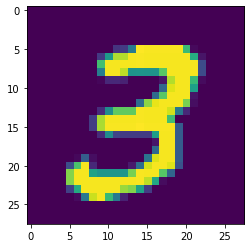

In [149]:
plt.imshow(X[7].reshape(28,28))

**DATA PREPROCESSING**

---

According to most literature available and the official MNIST website (http://yann.lecun.com/exdb/mnist/), most handwriting classification models based on Support Vector Machines (SVM) benefit from deskewing, that is the straightening of the numbers in the images.    
Therefore, all the images in the dataset were processed with deskewing, using the method available at https://fsix.github.io/mnist/Deskewing.html








In [150]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1])
    covariance_matrix = np.array([[m00,m01],[m01,m11]])
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


The results of deskewing can be appreciated in the images below

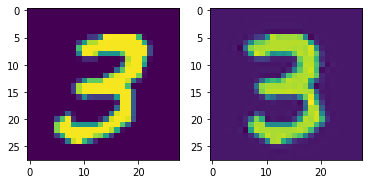

In [151]:
plt.subplot(1, 2, 1)
plt.imshow(X[7].reshape(28,28))

newim = deskew(X[7].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)

In [152]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X_deskewed = deskewAll(X)

Each feature is then transformed by rescaling to a value between 0 and 1

In [153]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X_deskewed)

The dataset is split into training and testing sets, with a test size 15% of the total

In [154]:
x_train, x_test, y_train, y_test = train_test_split(rescaledX, y, test_size=0.3, random_state=42)
data = {"train": {"X": x_train, "Y": y_train}, "test": {"X": x_test, "Y": y_test},}

In [155]:
samplesize = len(data["train"]["X"])

**PARAMETER TUNING**


---

The main parameters considered in the tuning of the model are:


*   **C** -> Regularization parameter
*   **kernel** -> kernel type used in the algorithm
*   **gamma** -> kernel coefficient

The only kernel considered for now is the RBF (or Gaussian) kernel; the C and gamma parameters will be selected with the grid search method.

In [156]:
gamma_range = [0.0001, 0.01, 1.0, 5]
C_range = [0.001, 0.1, 10, 50, 100]
parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}

In [157]:
gamma_range

[0.0001, 0.01, 1.0, 5]

In [158]:
C_range

[0.001, 0.1, 10, 50, 100]

In [159]:
svm_clf = svm.SVC()
grid_clf = GridSearchCV(estimator=svm_clf,param_grid=parameters, cv = 3, n_jobs=7, verbose=10)

In [160]:
start_time = dt.datetime.now()
print('Start param searching at {}'.format(str(start_time)))

Start param searching at 2020-10-09 13:37:27.039921


In [161]:
#grid_clf.fit(data["train"]["X"][:samplesize], data["train"]["Y"][:samplesize])

In [162]:
elapsed_time= dt.datetime.now() - start_time
print('Elapsed time, param searching {}'.format(str(elapsed_time)))

Elapsed time, param searching 0:00:00.019390


In [163]:
grid_clf = joblib.load(urlopen('https://github.com/matteobolner/AML_Basic/blob/master/grid_clf.pkl?raw=true'))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [164]:
grid_clf

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=1000,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=7,
             param_grid={'C': [0.1, 1, 10, 50, 100],
                         'gamma': [0.0001, 0.01, 1.0, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [165]:
print(grid_clf.cv_results_.keys())

classifier = grid_clf.best_estimator_
params = grid_clf.best_params_
scores = grid_clf.cv_results_['mean_test_score']

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [166]:
print("Best performing classifier:\n" + str(classifier))
print("\nBest parameters:\n" + str(params))
print("\nAll test scores:\n" + str(scores))

Best performing classifier:
SVC(C=50, break_ties=False, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best parameters:
{'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}

All test scores:
[0.55932651 0.95579592 0.19553059 0.1125102  0.91991842 0.97334695
 0.35477557 0.1125102  0.95091837 0.98218367 0.38485717 0.1125102
 0.96085716 0.98257143 0.38485717 0.1125102  0.96330613 0.98238776
 0.38485717 0.1125102 ]


In [167]:
#grid_clf.cv_results_

In [168]:
#predicted = grid_clf.predict(data["test"]["X"])
#print("Confusion matrix:\n%s" % metrics.confusion_matrix(data["test"]["Y"], predicted))
#print("Accuracy: %0.4f" % metrics.accuracy_score(data["test"]["Y"], predicted))


In [169]:
#print(sklearn.metrics.matthews_corrcoef(y_pred, data["test"]["Y"]))

In [170]:
params_df = pd.concat([pd.DataFrame(grid_clf.cv_results_["params"]),pd.DataFrame(grid_clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [171]:
params_df

,C,gamma,kernel,Accuracy
0,0.1,0.0001,rbf,0.559327
1,0.1,0.0100,rbf,0.955796
2,0.1,1.0000,rbf,0.195531
3,0.1,10.0000,rbf,0.112510
4,1.0,0.0001,rbf,0.919918
5,1.0,0.0100,rbf,0.973347
6,1.0,1.0000,rbf,0.354776
7,1.0,10.0000,rbf,0.112510
8,10.0,0.0001,rbf,0.950918
9,10.0,0.0100,rbf,0.982184


In [172]:
print("Best parameters set found on development set:")
print()
print(grid_clf.best_params_)
print()

Best parameters set found on development set:

{'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}



In [173]:
means = grid_clf.cv_results_['mean_test_score']
stds = grid_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
  print("%0.3f (+/-%0.03f) with %r" % (mean, std * 2, params))

0.559 (+/-0.002) with {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.956 (+/-0.002) with {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.196 (+/-0.002) with {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.113 (+/-0.000) with {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
0.920 (+/-0.004) with {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.973 (+/-0.001) with {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.355 (+/-0.004) with {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}
0.113 (+/-0.000) with {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.951 (+/-0.003) with {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.982 (+/-0.000) with {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.385 (+/-0.003) with {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}
0.113 (+/-0.000) with {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.961 (+/-0.002) with {'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}
0.983 (+/-0.000) with {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
0.385 (+/-0.003) with {'C': 50, 'gamma': 1.0, 'kernel': 'rbf'}
0.113 (+/-0.000) with {'C': 50, 'gamma': 1

In [174]:
# best parameters: {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
mnist_classifier = SVC(probability=False, kernel="rbf", C=50, gamma=0.01)
mnist_classifier.fit(data["train"]["X"][:samplesize], data["train"]["Y"][:samplesize])

SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

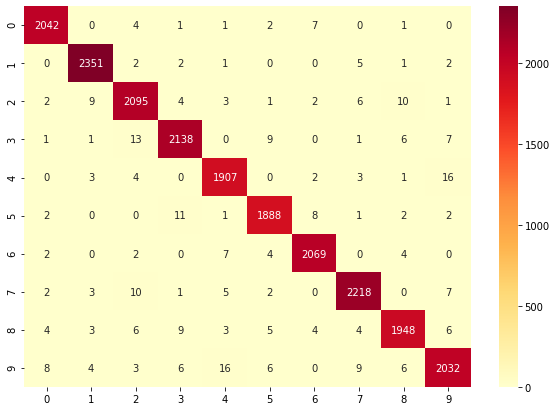

In [175]:
predicted = mnist_classifier.predict(data["test"]["X"])
df_cm = pd.DataFrame(metrics.confusion_matrix(data["test"]["Y"], predicted))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlOrRd", fmt="d")

In [176]:
error_rate = 100*(1 - metrics.accuracy_score(data["test"]["Y"], predicted))
print("Error rate: %0.4f"%error_rate)
print(metrics.accuracy_score(data["test"]["Y"], predicted))

Error rate: 1.4857
0.9851428571428571


In [177]:
metrics.matthews_corrcoef(data["test"]["Y"], predicted)


0.9834856625392243

In [178]:
print(metrics.classification_report(data["test"]["Y"], predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2058
           1       0.99      0.99      0.99      2364
           2       0.98      0.98      0.98      2133
           3       0.98      0.98      0.98      2176
           4       0.98      0.99      0.98      1936
           5       0.98      0.99      0.99      1915
           6       0.99      0.99      0.99      2088
           7       0.99      0.99      0.99      2248
           8       0.98      0.98      0.98      1992
           9       0.98      0.97      0.98      2090

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000



| Kernel| C | Gamma | Accuracy | MCC |
|---|---|---|---|---|
|RBF| 50 | 0.001 | 0.9718 | 0.9826
|RBF| 10 | 0.01 | 0.9844 | 0.9826
|RBF| 50 | 0.01 | 0.9851 | 0.9826
|RBF| 75 | 0.01 | 0.9848 | 0.9831
|RBF| 100 | 0.01 | 0.9849 | 0.9831
